In [4]:
import numpy as np
from math import pi

In [5]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [6]:
class GasLayer(object):
    def __init__(self, n_cells, d, k, R):
        self.n_cells = n_cells  #количество ячеек  
        self.d = d        #диаметр трубы 
        self.S = pi*d**2/4
        self.k = k        #показатель адиабаты газа
        self.R = R        #газовая постоянная
        self.q = 0        #масса газа в ячейке
        self.time = 0     #текущее время
        
        self.xs_borders = np.zeros(self.n_cells + 1) #координаты узлов
        self.Vs_borders = np.zeros(self.n_cells + 1) #скорости узлов
        
        self.us = np.zeros(self.n_cells)  #скорости потока газа в ячейках
        self.ps = np.zeros(self.n_cells)  #давления в ячейках
        self.ros = np.zeros(self.n_cells) #плотности газа в ячейках
        self.es = np.zeros(self.n_cells)  #удельная энергия газа в ячейках
        
    def copy(self):
        clone = GasLayer(n_cells=self.n_cells, d=self.d, k=self.k, R=self.R)
        clone.q = self.q
        clone.time = self.time
        clone.xs_borders[:] = self.xs_borders[:]
        clone.Vs_borders[:] = self.Vs_borders[:]
        clone.us[:] = self.us[:]
        clone.ps[:] = self.ps[:]
        clone.ros[:] = self.ros[:]
        clone.es[:] = self.es[:]
        return clone
    
    def set_init_condition(self, x_left, x_right, p_0, T_0):
        self.xs_borders = np.linspace(x_left, x_right, self.n_cells + 1)
        self.ps[:] = p_0
        ro_0 = p_0/(self.R*T_0)
        self.ros[:] = ro_0
        self.es[:] = 1/(self.k-1)* p_0/ro_0
        self.q = ro_0 * (self.xs_borders[1]-self.xs_borders[0])*self.S
    
    def get_tau(self, Ku):
        cs = np.sqrt(self.k * self.ps / self.ros)
        deltas = self.xs_borders[1:] - self.xs_borders[:-1]
        tau = Ku * np.min(deltas/(np.abs(self.us) + cs))
        return tau
    
    def step_up_lagrange(self, tau, m):
        """
        Метод не оптимален с точки зрения производительности + тут есть ошибки в формулах)
        """
        next_layer = self.copy()
        for i in range(self.n_cells-1):
            delta_p = self.ps[i+1] - self.ps[i]
            v_n1 = self.Vs_borders[i+1] - tau * delta_p * self.S / self.q
            x_n1 = self.xs_borders[i+1] + tau * v_n1
            next_layer.Vs_borders[i+1] = v_n1
            next_layer.xs_borders[i+1] = x_n1   
        v_n1 = self.Vs_borders[-1] + tau*self.ps[-1]*self.S/(0.5*self.q+m)
        x_n1 = self.xs_borders[-1] + tau * v_n1
        next_layer.Vs_borders[-1] = v_n1
        next_layer.xs_borders[-1] = x_n1    
        
        deltas = next_layer.xs_borders[1:] - next_layer.xs_borders[:-1]
        next_layer.ros = self.q/(self.S * deltas)
        
        for i in range(self.n_cells):
            vi1 = next_layer.Vs_borders[i+1]
            vi = next_layer.Vs_borders[i]
            e_n1 = self.es[i] - tau*self.S/self.q*self.ps[i]*(vi1-vi) # !!!
            p_n1 = (self.k-1)*next_layer.ros[i]*e_n1
            next_layer.ps[i] = p_n1
            next_layer.es[i] = e_n1
        next_layer.time = self.time + tau    
        return next_layer

In [7]:
# Пример создания, инициализации

layer = GasLayer(n_cells=300, d=0.03, k=1.4, R=287)
layer.set_init_condition(0, 0.5, 5e6, 300)
layer.get_tau(0.5)

2.4002316623378084e-06

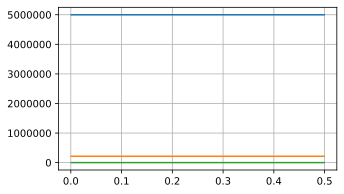

In [8]:
# Проверка значений, "лежащих" в слое

xs_cells = (layer.xs_borders[1:] + layer.xs_borders[:-1])/2
plt.plot(xs_cells, layer.ps)
plt.plot(xs_cells, layer.es)
plt.plot(xs_cells, layer.ros)
plt.grid(True)
plt.show()

In [9]:
# Пример решения прямой задачи

layer = GasLayer(n_cells=300, d=0.03, k=1.4, R=287)
layer.set_init_condition(0, 0.5, 5e6, 300)

res_V = [layer.Vs_borders[-1]]
res_p_dno = [layer.ps[0]]
res_p_porsh = [layer.ps[-1]]
res_t = [0]

res_layers = [layer]

for i in range(10000):
    if layer.xs_borders[-1] >= 2:
        break
    tau = layer.get_tau(0.5)
    layer = layer.step_up_lagrange(tau, 0.1)
    
    res_V.append(layer.Vs_borders[-1])
    res_p_dno.append(layer.ps[0])
    res_p_porsh.append(layer.ps[-1])
    res_t.append(layer.time)
    if i % 50 == 0:
        res_layers.append(layer)
    else:
        res_layers[-1] = layer
else:
    raise Exception('Слишком мало шагов( Снаряд не успел доехать до дульного среза')

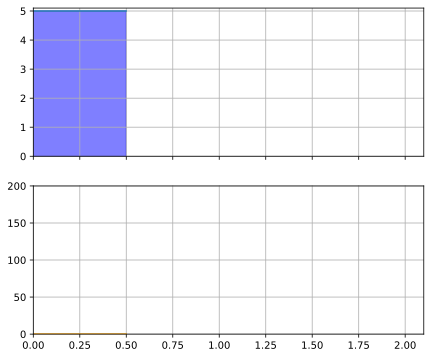

In [10]:
# Посмотреть, что происходило в лосях на протяжении расчета

from ipywidgets import interact, interactive, fixed
import ipywidgets

@interact(ind=ipywidgets.IntSlider(min=0,max=len(res_layers)-1,step=1, value=0))
def plotMe(ind):
    layer = res_layers[ind]
    xs_cells = (layer.xs_borders[1:] + layer.xs_borders[:-1])/2
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(7,6), gridspec_kw={'height_ratios':[2, 2]})
    xs = xs_cells
    ys = layer.ps/1e6
    ax1.plot(xs, ys)
    verts = [(xs[0], 0)] + list(zip(xs, ys)) + [(xs[-1], 0)]
    color= 'blue'
    alpha= 0.5
    poly = Polygon(verts, color=color, alpha=alpha)
    ax1.add_patch(poly)
    ax1.set_ylim(0,5.1)
    ax1.set_xlim(0,2.1)
    ax2.plot(layer.xs_borders, layer.Vs_borders, color='orange')
    xs = layer.xs_borders
    ys = layer.Vs_borders
    verts = [(xs[0], 0)] + list(zip(xs, ys)) + [(xs[-1], 0)]
    color= 'orange'
    alpha= 0.5
    poly = Polygon(verts, color=color, alpha=alpha)
    ax2.add_patch(poly)
    ax2.set_ylim(0,200)
    ax2.set_xlim(0,2.1)
    ax1.grid(True)
    ax2.grid(True)
    plt.show()

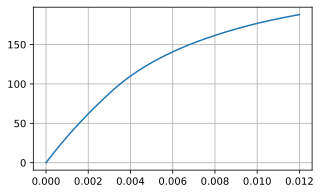

In [11]:
# график скорости метаемого элемента от времени

plt.plot(res_t, res_V)
plt.grid(True)
plt.show()

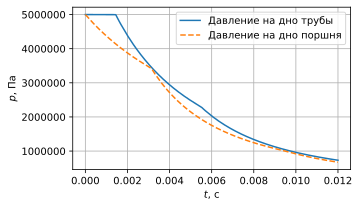

In [12]:
plt.plot(res_t, res_p_dno, label='Давление на дно трубы')
plt.plot(res_t, res_p_porsh, ls='--', label='Давление на дно поршня')
plt.grid(True)
plt.legend()
plt.xlabel('$t$, c')
plt.ylabel("$p$, Па")
plt.show()

##### Графики из методички
![](Screenshot_1.png)

### Тестовые данные

In [13]:
folder_path = r'./тестовые данные 1/' 
ts = np.load(folder_path+'ts')
Vs = np.load(folder_path+'Vs')
p_dno = np.load(folder_path+'p_dno')
p_porsh = np.load(folder_path+'p_porsh')

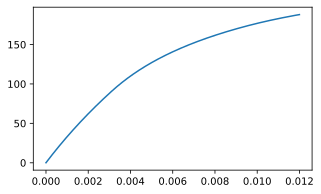

In [14]:
# график тестовых данных

plt.plot(ts, Vs)
plt.show()

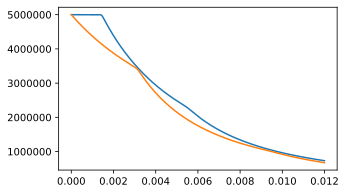

In [15]:
# Тоже тестовые данные 

plt.plot(ts, p_dno)
plt.plot(ts, p_porsh)
plt.show()

### Тестовые данные 2

Рабочей средой является некоторый вычислительный газ, представляющий собой совершенный газ с отношением удельных теплоемкостей, равным $γ=1.4$. В расчетах температуры полагается, что газовая постоянная равняется единице. Вычислительная энтропия пропорциональна физической энтропии и определяется как $s=ln(p/ργ
)$. Начальные условия представляют собой разрыв в точке $x=x_0$.

Численное решение задачи о распаде разрыва ищется на промежутке [0,1]. Разделительная перегородка располагается в точке $x_0=0.5$. Начальные условия задаются в физических переменных. На границах расчетного интервала используются условия зеркального отражения.

![](Screenshot_2.png)

In [16]:
folder_path = r'./тестовые данные 2/' 
es = np.load(folder_path+'es')
ms = np.load(folder_path+'ms')
ps = np.load(folder_path+'ps')
ros = np.load(folder_path+'ros')
us = np.load(folder_path+'us')
xs = np.load(folder_path+'xs')

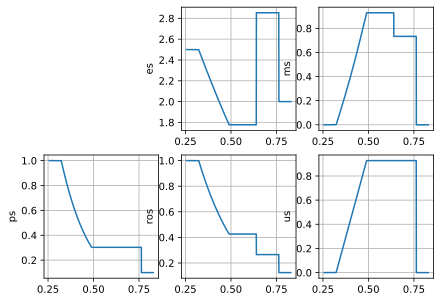

In [17]:
mpl.rcParams['figure.figsize'] = (7,5) 
plt.subplot(232)
plt.plot(xs, es)
plt.ylabel('es')
plt.grid(True)

plt.subplot(233)
plt.plot(xs, ms)
plt.ylabel('ms')
plt.grid(True)

plt.subplot(234)
plt.plot(xs, ps)
plt.ylabel('ps')
plt.grid(True)

plt.subplot(235)
plt.plot(xs, ros)
plt.ylabel('ros')
plt.grid(True)

plt.subplot(236)
plt.plot(xs, us)
plt.ylabel('us')
plt.grid(True)

plt.show()

***
***
## Пример решения обратной задачи

### вариант № *несуществующий*

Найти массу метаемого тела $m$ и длину камеры $l_0$, при которых достигается максимальная кинетическая энергия $E_Д$ метаемого тела при вылете из трубы калибра $d$. Общая длина трубы не более $n$ калибров. Наибольшая длина камеры не более 3/4 общей длины трубы. Начальное давление газа не более $p_{max}$. Начальная температура газа в камере $T_0=500 \, К$.

Необходимые денные:
 - газ: воздух ($k=1.4$ $R=287$);
 - $d=0.025 \, м$;
 - $n=40$ ($x_m=1 \,м$);
 - $p_{max}=15 \, МПа$;
 - $10\,г \le m \le 500\,г$.

### Шаг 1.

Проанализируем условие задачи, попробуем сократить количество варьируемых параметров.

 1. Очевидно), что при прочих равных условиях бОльшая скорость (и соотв. дульная энергия) будет достигаться при бОльшем начальном давлении газа. Следовательно, начальное давление не будет варьироваться и для всех рассматриваемых вариантов будет равно максимально допустимому давлению $p_{max}=15 \, МПа$.
 1. Также очевидно), что при прочих равных условиях бОльшая скорость (и соотв. дульная энергия) будет достигаться при бОльшей длине трубы (т.к. сила сопротивления на метаемый элемент отсутствует). Следовательно, длина трубы не будет варьироваться и для всех рассматриваемых вариантов будет равна максимально допустимомой длине трубы $n=40$ ($x_m=dn=1 \,м$).
 
Получается, что у нас остается два варьируемых параметра: 
 - длина камеры $l_0$;
 - масса метаемого элемента $m$.

### Шаг 2.
Определим мета параметры для нашей задачи (количество ячеек в сетке).

Найдем такие параметры, при которых прямая задача будет решаться как можно быстрее, но при этом не будет терять в точности (не более 0.1%) 

Сравнивать будем с максимально точным решением (количество ячеек 1000, число Куранта 0.3)

In [18]:
def one_forward(m, l_0, n_cells, Ku):
    """
    Функция решения прямой задачи, возвращает дульную энергию и время вылета
    m [кг]
    l_0 [м]
    
    returns (E_d, ball_time)
    """
    d = 0.025
    p_0 = 15e6
    x_m = 1
    gl = GasLayer(n_cells=n_cells, d=d, k=1.4, R=287)  # воздух
    gl.set_init_condition(x_left=0, x_right=l_0, p_0=p_0, T_0=300)
    for i in range(100000):
        if gl.xs_borders[-1] >= x_m:
            break
        tau = gl.get_tau(Ku)
        gl = gl.step_up_lagrange(tau, m)
    else:
        raise Exception(f'Что-то долго считается m={m}, l_0={l_0}, n_cells={n_cells}, Ku={Ku}')
    V_d = gl.Vs_borders[-1]
    E_d = m*V_d**2/2
    return (E_d, gl.time)

In [19]:
# максимально точное решение для Н.У. m=10г, l_0=0.25
E_etalon, t_ball_etalon = one_forward(m=10e-3, l_0=0.25, n_cells=1000, Ku=0.3)

In [20]:
print(E_etalon, t_ball_etalon)

1141.7487427425801 0.002318884904441158


In [21]:
# Считалось это безобразие вот сколько 19.3 s ± 415 ms
# раскомментируй следующую строчку для самостоятельного расчета
# %timeit one_forward(m=10e-3, l_0=0.25, n_cells=1000, Ku=0.3)

27.3 s ± 1.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


переберем несколько вариантов количества ячеек

In [26]:
from tqdm import tqdm

ncls = np.arange(25, 350, 25)
Ecls = []
tbs = []
for n_cells in tqdm(ncls):
    E, t_ball = one_forward(m=10e-3, l_0=0.25, n_cells=n_cells, Ku=0.3)
    Ecls.append(E)
    tbs.append(t_ball)
Ecls = np.array(Ecls)
tbs = np.array(tbs)

100%|████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/it]


[]

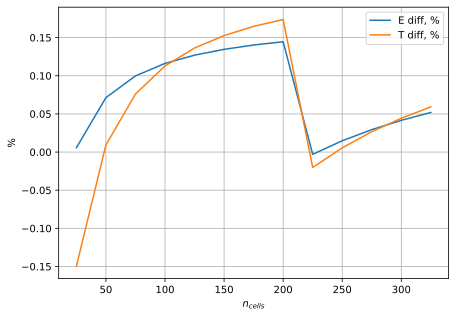

In [27]:
# найдем отклонение от эталонного решения
plt.plot(ncls, (Ecls-E_etalon)/E_etalon*100, label='E diff, %')
plt.plot(ncls, (tbs-t_ball_etalon)/t_ball_etalon*100, label='T diff, %')
plt.grid()
plt.ylabel('%')
plt.xlabel('$n_{cells}$')
plt.legend()
plt.plot()

Подходит 250 ячеек (т.к. в окрестности этого выбора максимальные отклонения от эталонного решения не превышает заданный порог 0.1%)

In [28]:
n_cells_good=250

In [29]:
# 220 ячеек же считается 1.2 s ± 39.6 ms, что в 15 раз быстрее
%timeit one_forward(m=10e-3, l_0=0.25, n_cells=n_cells_good, Ku=0.3)

1.54 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Шаг 3

Составим план вычислений.

План следующий: 
 1. Определим диапазоны варьируемых параметров.
 2. В полученной прямоугольной параметрической области будем находить решения прямых задач в случайных точках. И сохранять результаты в файл.
 3. Будем продолжать это делать, пока не станет ясна характер поверхности отклика.
 4. Выбрать, реализовать и протестировать детерминированный алгоритм поиска.
 5. В области предполагаемого максимума найдем максимум с заданной точностью при помощи реализованного детерминированного алгоритма поиска. В качестве начальной точки возьмем лучшую точку из файла.

#### шаг 3.1

Диапазоны варьируемых параметров:
 - $10\,г \le m \le 500\,г$;
 - $100\,м \le l_0 \le 750\,мм$


In [30]:
m_min = 10
m_max = 500

l_min = 100
l_max = 750

#### шаг 3.2
Начинаем разыгрывать по 100 случайных точек и записывать результат в файл-таблицу (rnd_results.csv).
 - Первая колонка - масса метаемого тела, г
 - Вторая - длина камеры, мм
 - третья - дульная энергия, Дж


In [33]:
a = (1,2,3)
s,d,f = a
d

2

In [35]:
FILE_PATH = 'rnd_results.csv'
import csv

def one_point_calc_and_save(m, l_0, fp=FILE_PATH):
    try:
        E, t_ball = one_forward(m=m*1e-3, l_0=l_0*1e-3, n_cells=n_cells_good, Ku=0.3)
        with open(fp, 'a', newline="") as file:
            writer = csv.writer(file, delimiter=";")
            writer.writerow([m, l_0, E])
        return E
    except Exception as e:
        print(f'Ошибка "{e}" в точке m={m}, l_0={l_0}')
        return -1

In [36]:
# розыгрыш точек во всей допустимой области

for i in tqdm(range(10)):
    m = np.random.uniform(low=m_min, high=m_max)
    l_0 = np.random.uniform(low=l_min, high=l_max)
    one_point_calc_and_save(m, l_0)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.16s/it]


In [78]:
# розыгрыш точек во более узкой области (предполагаемого максимума)

# for i in tqdm_notebook(range(100)):
#     m = np.random.uniform(low=300, high=500)
#     l_0 = np.random.uniform(low=300, high=600)
#     one_point_calc_and_save(m, l_0)

#### шаг 3.3
После каждого мини-расчета строим график поверхности отклика.


In [40]:
# загружаем все сохраненные точки
ms = []
ls = []
es = []
with open(FILE_PATH, 'r', newline="") as file:
    reader = csv.reader(file, delimiter=";")
    for m,l,e in tqdm(reader):
        ms.append(float(m))
        ls.append(float(l))
        es.append(float(e))

ms = np.array(ms)
ls = np.array(ls)
es = np.array(es)

420it [00:00, 104845.12it/s]


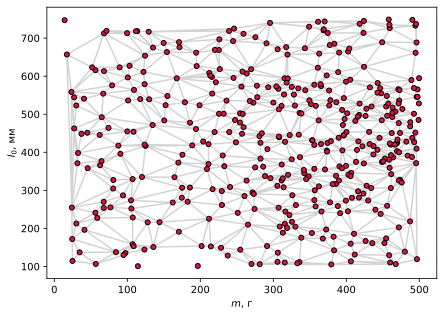

In [38]:
# рисуем график 1
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

triang = mtri.Triangulation(ms, ls)
m_del = (np.max(ms)-np.min(ms))/100*0.5
l_del = (np.max(ls)-np.min(ls))/100*0.5
isBad = np.where((ms<np.min(ms)+m_del) | (ms>np.max(ms)-m_del) | (ls<np.min(ls)+l_del) | (ls>np.max(ls)-l_del), True, False)
mask = np.any(isBad[triang.triangles],axis=1)
triang.set_mask(mask)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="#DC143C", markeredgecolor="black", markersize=10)

ax.set_xlabel('$m$, г')
ax.set_ylabel('$l_0$, мм')
plt.show()

In [26]:
# %matplotlib inline
# %matplotlib 

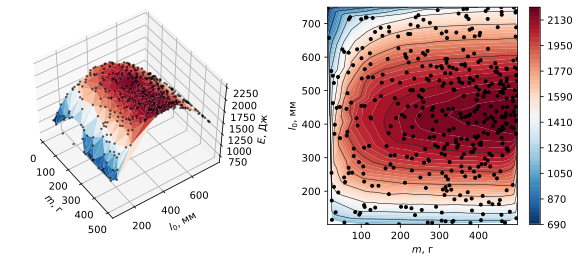

In [39]:
# график 2

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1, projection='3d')

ax.plot_trisurf(triang, es, cmap='RdBu_r')
ax.scatter(ms, ls ,es, marker='.', s=10, c="black", alpha=0.5)
ax.view_init(elev=50, azim=-35)

ax.set_xlabel('$m$, г')
ax.set_ylabel('$l_0$, мм')
ax.set_zlabel('$E$, Дж')

ax2 = fig.add_subplot(1,2,2)

ax2.tricontour(ms, ls ,es, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(ms, ls ,es, levels=50, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(ms, ls, 'ko', ms=3)

ax2.set_xlabel('$m$, г')
ax2.set_ylabel('$l_0$, мм')

plt.subplots_adjust(wspace=0.35)

plt.show()


#### шаг 3.4

Детерминированный алгоритм поиска необходим для нахождения локального (относительно начальной точки поиска) максимума с заданной точностью. Алгоритм должен уметь находить экстремум даже, если он находится на границе параметрической области.

В качестве примера реализуем простой метод детерминированного поиска [Гаусса — Зейделя](https://en.wikipedia.org/wiki/Coordinate_descent)

В качестве тестовой функции будем использовать функцию вида:
$$f(x,y)=100-(x^2+y^2+xy)$$
$$x\in[0, 3]$$
$$y\in[-3, 3]$$

У данной функции максимум находится на границе параметрической области в точке $(x=0,\,y=0)$; $f(0,0)=100$. Напишем функцию численного поиска максимума, реализующую данный метод детерминированного поиска. Поиск будем осуществлять с точностью $0.05$ по координате $x$ и $0.1$ по $y$.

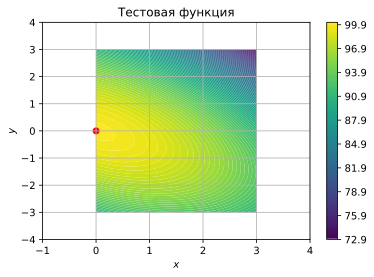

In [41]:
# график тестовой функции

def test_foo(x,y):
    return 100-(x**2+y**2+x*y)

x1, x2 = 0, 3
y1, y2 = -3, 3

xs = np.linspace(x1, x2)
ys = np.linspace(y1, y2)
X, Y = np.meshgrid(xs, ys)

fs = test_foo(X, Y)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

cntr = ax.contourf(X, Y, fs, levels=100)
ax.scatter([0],[0], color='r')
fig.colorbar(cntr, ax=ax)
ax.set_xlim(-1,4)
ax.set_ylim(-4,4)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
plt.title('Тестовая функция')
plt.show()

In [42]:
# функция поиска реализована далеко не идеально, оптимизирует только функции с двумя параметрами
def optim_gauss_zaid(foo, x_0, y_0, f_0, dx, dy, x_min, x_max, y_min, y_max, n_max=300):
    """
    foo - функция для оптимизации
    x_0 - коодината x начальной точки (та, от которой алгоритм начинает искать максимум)
    y_0 - координата y начальной точки
    f_0 - значение функции в начальной точке
    dx - шаг (точность) по координате x
    dy - шаг (точность) по координате y
    x_min, x_max - допустимые границы параметра x
    y_min, y_max - допустимые границы параметра y
    n_max - максимальное количество точек для расчета 
    
    функция возвращает флаг, успешно ли мы добрались до максимума, 
    значение максимума,
    координаты максимума,
    список кортежей (foo(x,y), x, y) всех точек, рассчитанных алгоритмом в процессе поиска
    """
    done = False
    n_calced = 0
    history = [(f_0, x_0, y_0)]
    while not done:
        improvments = False
        for v in [(dx, 0), (0, dy), (-dx, 0), (0, -dy)]:  
            any_improvments, f_0, (x_0, y_0) = move_to_v(foo, 
                                                         f_0=f_0, 
                                                         p_0=(x_0, y_0), 
                                                         v=v, 
                                                         b=[(x_min, x_max), (y_min, y_max)], 
                                                         n_max=n_max, 
                                                         history=history)
            if len(history) >= n_max:
                break
            improvments = improvments or any_improvments
        done = not improvments

    return done, f_0, x_0, y_0, history
            
def move_to_v(foo, f_0, p_0, v, b, n_max, history=None):
    """
    Вспомогательная функция. Ищет максимум функции от точки p_0 в направлении v. Имеет ограничение по количеству расчетных точек (n_max),
    И, если history - список, то в него будут добавляться кортежи (foo(*p), *p)
    
    returns кортеж (
        any_improvments {bool} - улучшили ли мы результат
        f_max - значение максимума
        p_max - координаты максимума
    )
    """
    n = 0 if history is None else len(history)
    any_improvments = False
    p_1 = get_next_p(p_0, v, b)
    while p_1:
        f_1 = foo(*p_1)
        n += 1
        if history:
            history.append((f_1, *p_1))     
        if f_1 > f_0:
            f_0, p_0 = f_1, p_1
            any_improvments = True
            p_1 = get_next_p(p_0, v, b)
        else:
            break
    return any_improvments, f_0, p_0
  
def get_next_p(p_0, v, b):
    p = tuple([xp+xv for xp, xv in zip(p_0, v)])
    t = 1
    for x, x_0, (x_min, x_max) in zip(p, p_0, b):
        if abs(x-x_0)<1e-12:
            continue
        if x < x_min:
            t = min(t, (x_min-x_0)/(x-x_0))
        elif x > x_max:
            t = min(t, (x_max-x_0)/(x-x_0))
    if abs(t) < 1e-12:
        return None
    return tuple([xp+xv*t for xp, xv in zip(p_0, v)])

Найдем максимум тестовой функции, стартуя из различных точек

In [43]:
# из точки (2, -2)
success, fm1, xm1, ym1, history1 = optim_gauss_zaid(test_foo, 2, -2, test_foo(2,-2), 0.05, 0.1, x1, x2, y1, y2, n_max=300)
print('Мы нашли максимум' if success else 'Мы не нашли максимум')
print(f'Максимум в точке ({xm1:.3f}, {ym1:.3f}), значение функции {fm1}')

Мы нашли максимум
Максимум в точке (0.000, 0.000), значение функции 100.0


In [44]:
# из точки (1.5, 3)
success, fm2, xm2, ym2, history2 = optim_gauss_zaid(test_foo, 1.5, 3, test_foo(1.5, 3), 0.05, 0.1, x1, x2, y1, y2, n_max=300)
print('Мы нашли максимум' if success else 'Мы не нашли максимум')
print(f'Максимум в точке ({xm2:.3f}, {ym2:.3f}), значение функции {fm2}')

Мы нашли максимум
Максимум в точке (0.000, -0.000), значение функции 100.0


In [45]:
# из точки (0, -3)
success, fm3, xm3, ym3, history3 = optim_gauss_zaid(test_foo, 0, -3, test_foo(0, -3), 0.05, 0.1, x1, x2, y1, y2, n_max=300)
print('Мы нашли максимум' if success else 'Мы не нашли максимум')
print(f'Максимум в точке ({xm3:.3f}, {ym3:.3f}), значение функции {fm3}')

Мы нашли максимум
Максимум в точке (0.000, 0.000), значение функции 100.0


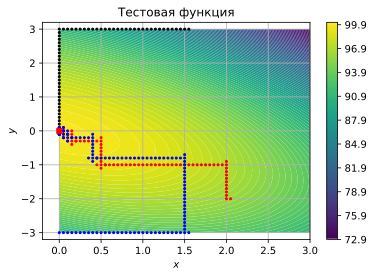

In [46]:
# график пути функции поиска

def test_foo(x,y):
    return 100-(x**2+y**2+x*y)

x1, x2 = 0, 3
y1, y2 = -3, 3

xs = np.linspace(x1, x2)
ys = np.linspace(y1, y2)
X, Y = np.meshgrid(xs, ys)

fs = test_foo(X, Y)



fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

cntr = ax.contourf(X, Y, fs, levels=100)

xs = [x for f, x, y in history1]
ys = [y for f, x, y in history1]
ax.plot(xs, ys, 'o', color='r', markersize=2)

xs = [x for f, x, y in history2]
ys = [y for f, x, y in history2]
ax.plot(xs, ys, 'o', color='black', markersize=2)

xs = [x for f, x, y in history3]
ys = [y for f, x, y in history3]
ax.plot(xs, ys, 'o', color='b', markersize=2)
ax.plot([xm2], [ym2], 's', color='r', markersize=5)

fig.colorbar(cntr, ax=ax)
ax.set_xlim(-0.2,3)
ax.set_ylim(-3.2,3.2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
plt.title('Тестовая функция')
plt.show()

#### шаг 3.5

Уже после расчета прямой задачи в 400 случайных точках можно сделать вывод о достаточной монотонности поверхности отклика.

Точные координаты максимума найдем при помощи реализованного метода [Гаусса — Зейделя](https://en.wikipedia.org/wiki/Coordinate_descent)

Будем искать координаты (и значение) максимума с точностью $0.01$ г по координате $m$ и $0.05$ мм по координате $l_0$

Также мы будем сохранять результаты в другой файл, чтобы потом можно было визуализировать работу алгоритма

In [34]:
# лучшая точка
m0 = ms[np.argmax(es)]
l0 = ls[np.argmax(es)]
e0 = es[np.argmax(es)]
print(f'Пока что лучшая точка m = {m0:.1f} г,  l_0 = {l0:.1f} мм, E_d = {e0:.1f} Дж')

Пока что лучшая точка m = 496.2 г,  l_0 = 409.6 мм, E_d = 2211.4 Дж


In [49]:

dm = 0.01 # г
dl = 0.05 # мм

# путь к файлу
FILE_PATH2 = 'determ.csv'

e_max=e0

def foo(m, l):
    global e_max
    e = one_point_calc_and_save(m, l, FILE_PATH2)
    if e > e_max:
        e_max = e
        print(f'New champ {e}')
    return e

NameError: name 'e0' is not defined

In [36]:
# success, em, mm, lm, history = optim_gauss_zaid(
#     foo=foo, 
#     x_0=m0, 
#     y_0=l0, 
#     f_0=e0, 
#     dx=dm*100,  # сначала найдем более грубое решение (в 100 раз более грубое)
#     dy=dl*100, 
#     x_min=m_min, 
#     x_max=m_max, 
#     y_min=l_min, 
#     y_max=l_max, n_max=200)
# success

In [37]:
# success, em, mm, lm, history = optim_gauss_zaid(
#     foo=foo, 
#     x_0=mm, 
#     y_0=lm, 
#     f_0=em, 
#     dx=dm*25, # теперь чуть точнее
#     dy=dl*25, 
#     x_min=m_min, 
#     x_max=m_max, 
#     y_min=l_min, 
#     y_max=l_max, n_max=200)
# success

In [47]:
# success, em, mm, lm, history = optim_gauss_zaid(
#     foo=foo, 
#     x_0=mm, 
#     y_0=lm, 
#     f_0=em,
#     dx=dm*10, # теперь еще чуть точнее
#     dy=dl*10, 
#     x_min=m_min, 
#     x_max=m_max, 
#     y_min=l_min, 
#     y_max=l_max, n_max=200)
# success

In [39]:
# success, em, mm, lm, history = optim_gauss_zaid(
#     foo=foo, 
#     x_0=mm, 
#     y_0=lm, 
#     f_0=em,
#     dx=dm, # теперь точно
#     dy=dl, 
#     x_min=m_min, 
#     x_max=m_max, 
#     y_min=l_min, 
#     y_max=l_max, n_max=200)
# success

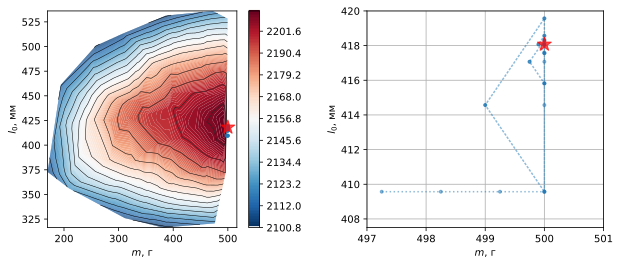

In [50]:
# загружаем все сохраненные точки
ms = []
ls = []
es = []
with open(FILE_PATH, 'r', newline="") as file:
    reader = csv.reader(file, delimiter=";")
    for m,l,e in tqdm_notebook(reader):
        if float(e)<2100:
            continue
        ms.append(float(m))
        ls.append(float(l))
        es.append(float(e))

ms = np.array(ms)
ls = np.array(ls)
es = np.array(es)

triang = mtri.Triangulation(ms, ls)
# m_del = (np.max(ms)-np.min(ms))/100*0.5
# l_del = (np.max(ls)-np.min(ls))/100*0.5
# isBad = np.where((ms<np.min(ms)+m_del) | (ms>np.max(ms)-m_del) | (ls<np.min(ls)+l_del) | (ls>np.max(ls)-l_del), True, False)
# mask = np.any(isBad[triang.triangles],axis=1)
# triang.set_mask(mask)

fig = plt.figure(figsize=(10,4))
ax2 = fig.add_subplot(1,2,1)

ax2.tricontour(ms, ls ,es, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(ms, ls ,es, levels=150, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
# ax2.plot(ms, ls, 'ko', ms=3)

ax2.set_xlabel('$m$, г')
ax2.set_ylabel('$l_0$, мм')



ms = []
ls = []
es = []
with open(FILE_PATH2, 'r', newline="") as file:
    reader = csv.reader(file, delimiter=";")
    for m,l,e in tqdm_notebook(reader):
        ms.append(float(m))
        ls.append(float(l))
        es.append(float(e))

ms = np.array(ms)
ls = np.array(ls)
es = np.array(es)

mm = ms[np.argmax(es)]
lm = ls[np.argmax(es)]
        
ax2.plot(ms, ls, 'o:', ms=3, alpha=0.5)
ax2.plot([mm], [lm], '*', ms=15, c='r', alpha=0.7)

ax3 = fig.add_subplot(1,2,2)
ax3.plot(ms, ls, 'o:', ms=3, alpha=0.5)
ax3.plot([mm], [lm], '*', ms=15, c='r', alpha=0.7)
ax3.set_xlabel('$m$, г')
ax3.set_ylabel('$l_0$, мм')
ax3.set_xlim(497,501) 
ax3.set_ylim(407.5,420)
ax3.grid()
plt.subplots_adjust(wspace=0.35)
plt.show()
